In [1]:
#import all the necessary libraries
import pandas as pd 
import numpy as  np
import re

from sklearn.feature_extraction.text import TfidfVectorizer

#import all the necessary libraries to build a neural network classifier from tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential                   
from tensorflow.keras.layers import Dense                        #import fully connected neural net layers
from tensorflow.keras.optimizers import Adam                     #choose adam as the optimization algorithm
from tensorflow.keras.losses import CategoricalCrossentropy      #cost function needed for softmax classification if the labels are 
                                                                 #one hot encoded

from tensorflow.keras.regularizers import l2                     #add regularization in order to avoid overfitting 

from sklearn.model_selection import train_test_split             #to split the training set into train and test set 

from sklearn.metrics import confusion_matrix, classification_report  #to proceed with error analysis on our predictions


import seaborn as sns                                                 #to visualize confusion matrices as a heatmap
import matplotlib.pyplot as plt


from tensorflow.keras.layers import LSTM, Dropout              #import long-short term memory neural net layers
                                                               #and dropout regularization layers

In [4]:
def  vectorize_string_csv_column_TF_idf(string_column):  
                                                #create a function that receives a column of strings from a csv file 
                                                  #and converts each entry into a unique tfidf vector depending on the 
                                                  #unique vocabulary
                                                   
                                                 #necessary to convert a text input into a numeric vector to be used 
                                                 #as input to the classifier

    
    tfidf_vectorizer = TfidfVectorizer()  
                                      #create a TF_idf_vectorizer model that will receive the entire csv column
                                      #and will eventually turn each entry into a numeric vector
                                      #the length of each vector will be the number of the unique words in the vocabulary
                                      #if this length=N the resulting vectors for each entry will be of dimension (N,)
    
    tfidf_matrix = tfidf_vectorizer.fit_transform(string_column)  
                                                    #apply the created model to the column title of the csv


    tfidf_vectors = tfidf_matrix.toarray()          #each entry of the tfidf_vectors is a numeric vector
                                                    #corresponding to a title entry
                                                    #convert it to an array format for ease of handling

    Vocabulary=tfidf_vectorizer.get_feature_names_out()  #export the unique vocabulary out of the created vectorizer model

    return tfidf_vectors, Vocabulary   

In [7]:
#create a function that finds all the unique labels in a column 
def find_unique_column_labels(column):
     
    unique_labels_list=[]               #create a list that will contain all the unique labels found in the input column

    for i in column : #search the entire column
        if i not in unique_labels_list:   #if the element i is not found in the unique list 
            unique_labels_list.append(i)  #append it to the list
    
    return  unique_labels_list 

In [10]:
def one_hot_encode_labels(unique_labels_of_a_column):
    #create a dictionary for these categories that coresponds each one into a one hot numpy vector
    #this is necessary in order to use a softmax classifier 

    number_of_classes=len(unique_labels_of_a_column)  #find the number of classes/possible labels from the vector that contains the unique labels

                                               #create a numpy I matrix I lxl where l is the number of classes 
                                               #each row of the I matrix will correspond to a one hot encoding for each label
    I=np.eye(number_of_classes)

    #create a dictionary to correspond each class name with it's one hot encoded label

    dict_labels={} #initialize an empty dictionary where the keys will be the labels and the values will be their one hot encoding


    for i in range(number_of_classes):
        dict_labels[unique_labels_of_a_column[i]]=I[i,:]

    return dict_labels

In [13]:
def create_Y_label(initial_label_column,dict_labels):
    #create the Y part of the dataset by receiving  a column  and the dict_labels corresponding to that column



    #len(dict_labels['biological'])

    Y1={}   #initialize an empty dictionary
    count=0 #and a count variable
    for i in initial_label_column:    #search through the hazard_category column of the data frame
        for j in dict_labels.keys():  #and through all the keys of the labels dictionary with keys all the unique labels 
                                  #and values their one hot encoded representation
            if i==j:                   #if you find a match
                Y1[count]=dict_labels[j]   #assign the category with it's one hot encoding
                count+=1
    #Y
    #now the dictionary above should be turned into a numpy matrix with its elements being column vectors

    # Convert dictionary values to a numpy matrix
    matrix = np.array([v for v in Y1.values()]).T

    matrix.shape #Nxm format
    return matrix    

In [16]:
def train_and_eval_dense_nn(X_train,Y_train,X_test,Y_test,hu_1,hu_2,number_of_classes,a_epochs,a_batch_size):
    #define a function that trains a fully connected dense neural net to fit the pre-processed data
    #X_train are the training data
    #Y_train are the training labels 
    #X_test,Y_test are the data we are going to use for validation
    #hu_1 is the number of hidden units in layer 1
    #hu_2 is the number of hidden units in layer 2
    #number of classes is self explanatory and it is required for the softmax classification layer
    #a_epochs is the number of training epochs 
    #and a_batch size is the number of batches that we use to split the training data
    #the activation function is chosen as the relu activation f(z)=max(z,0)
    #and the regularization is set to zero after manual tuning
    
    model = Sequential([                                          #model architecture    
    Dense(hu_1, activation='relu', input_shape=(X_train.shape[1],),kernel_regularizer=l2(0)),  
    Dense(hu_2, activation='relu',kernel_regularizer=l2(0)),                      
    Dense(number_of_classes, activation='softmax',kernel_regularizer=l2(0))         
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),           #for training the model the Adam optimization algorithm has been chosen 
                                                                  #with initial learning rate=0.001
        loss=CategoricalCrossentropy(),                            #since the output labels are one-hot encoded we have chosen the 
                                                                 #Categorical cross entropy function as a loss function
        metrics=['accuracy'])

    model.fit(     #the method fit is used to actually train the model using the X_train and Y_train 
    X_train, Y_train,    #as training data and X_test,Y_test as validation data 
    validation_data=(X_test, Y_test),
    epochs=a_epochs,          #the number of epochs chosen for the training are 30
    batch_size=a_batch_size,     #the training itself is mini batch gradient-descent with adam and the training data -set is split into 
    verbose=1          #32 batches    
    )


    test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)   #we now evaluate the models performance on the
                                                                       #X_test and Y_test data for which we now the labels 
                                                                       #but these labels are unkown to the model 
                                                                       #using only the input data X_test it predicts the output 
                                                                       #labels and then compares them with the actual Y_test labels

    print("Test Loss:", test_loss)                           #depict the final value of the cost function for the test set                                     
    print("Test Accuracy:", test_accuracy)                  #depict the accuracy of predictions in the test set



    
    return model

In [18]:
def create_heatmap_and_error_report(model,X_test,Y_test,num_of_classes):  #input the X_test 
                                                                    #and Y_test
                                                                    #make predictions on X_test with the model
                                                                    #compare the model predictions with 
                                                                    #the actual Y_test and create an error analysis

    
    Y_predict_initial=model.predict(X_test) #we predict the model output for the X_test 
        #and we are going to compare with the actual lables from Y_test

    #Each entry y in Y_predict_initial is a vector of  outputs= number of classes, containing the probabilities that show 
    #how likely it is for the model to assign an entry x of x_test to a specific class.
    #For the entry x with prediction y if y[0] is the highest amongst the elements of y, x will be assigned to 
    #class 0. If y[1] is the highest then x will be assigned to class_1 and so on

    #As a result, we need to find the index of  maximum element of each y in Y_predict 
    #that will show us in which class x corresponds to:
    Y_intermediate = np.argmax(Y_predict_initial, axis=1) #find the index of the maximum element for each y in Y_predict_initial
    
    #we are also going to convert Y_test from a one hot encoding to 
    #the number of class this one hot encoding represents and compare it with 
    #the predicted class stored in Y_intermediate

    Y_true = np.argmax(Y_test, axis=1)  #due to the fact that we have a one hot encoding, finding the index of the max 
                                    #element will lead directly to the number of class it represents

    #
    #we are going to find out where Y_true matches our prediction in Y_intermediate 
    #and we are going to display a confusion matrix of the true vs the prediction

    
    conf_mat=confusion_matrix(Y_true,Y_intermediate)
    

    sns.heatmap(conf_mat,annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.show()

    #the classification report is applied to the test set which is a random split from the entire training set
    #as a result it may not include the entire number of classes and we will get the error report based on the 
    #classes stored in the confusion matrix and the test set
    report = classification_report(Y_true, Y_intermediate, target_names=[f"Class {i}" for i in range(conf_mat.shape[0])]) 
    print("\n",report)

    return 1

In [20]:
#make a function that inputs data X
#the model that makes predictions and the 
#dictionary with the labels and their one hot encoding. 
#It computes the numeric predictions for X and turns them into the text of the label 
#they correspond to

def from_pred_and_dictionary_to_labels(X,model,one_hot_dictionary):
    
        #predicted output
    Y_pr=model.predict(X)

        #create a new dictionary with the key being the index/label of the one_hot_dictionary
        #and the value of this new  dictionary being the phrase of the one hot encoding 

    new_dict={}

    for key,value in one_hot_dictionary.items():   
        convert_one_hot_encode_to_number=np.argmax(value)    #get the number representation of the one hot encoding
        label=key                                            #get the phrase of the one hot encoding 
        new_dict[convert_one_hot_encode_to_number]=label     #store them as number-> phrase

    #use the newly created dictionary to map the predictions into the labels
    predictions_text_format=[]

    for i in Y_pr:
        chosen_label=np.argmax(i) #loop through the predictions of the model and choose to which label the prediction is assigned
        predictions_text_format.append(new_dict[chosen_label]) #get the phrase corresponding to that label and append it to a list
        
    return predictions_text_format

In [23]:
#load the csv incidents_train into a data frame

df=pd.read_csv('incidents_train.csv')
#df.head()

#isolate the text category which is to be used as the input X to a classifier
text=df['text']

In [26]:
X,unique_text_voc=vectorize_string_csv_column_TF_idf(text)
#X.shape

In [29]:
hazard_category=df['hazard-category']  #get the hazard category for the data frame refering to the training set
unique_hazard_category_labels=find_unique_column_labels(hazard_category) #find the unique labels of product category


one_hot_encode_hazard_category=one_hot_encode_labels(unique_hazard_category_labels)#one hot encode these labels and get a 
#dictionary with the key being the label and the value being its one hot encoding
#one_hot_encode_hazard_category

Y_hazard_category_transposed=create_Y_label(hazard_category,one_hot_encode_hazard_category)
#create the Y part of the data-set but in a transposed format

Y_hazard_category=Y_hazard_category_transposed.T
Y_hazard_category.shape

(5082, 10)

In [31]:
one_hot_encode_hazard_category

{'biological': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'foreign bodies': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'chemical': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'fraud': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 'organoleptic aspects': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 'allergens': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 'packaging defect': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 'other hazard': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 'food additives and flavourings': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 'migration': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}

In [33]:
#split the data intro train and test set
#using the processed title data as X
#and hazard category as Y
X_train, X_test, Y_hazard_category_train, Y_hazard_category_test = train_test_split(X, Y_hazard_category, test_size=0.2, random_state=42)


In [35]:
model=train_and_eval_dense_nn(X_train,Y_hazard_category_train,X_test,Y_hazard_category_test,256,120,10,3,32)

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.6160 - loss: 1.4800 - val_accuracy: 0.8102 - val_loss: 0.6053
Epoch 2/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.9035 - loss: 0.3589 - val_accuracy: 0.8791 - val_loss: 0.4153
Epoch 3/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.9696 - loss: 0.1310 - val_accuracy: 0.8869 - val_loss: 0.3929
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8849 - loss: 0.4435
Test Loss: 0.3929406702518463
Test Accuracy: 0.886922299861908


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


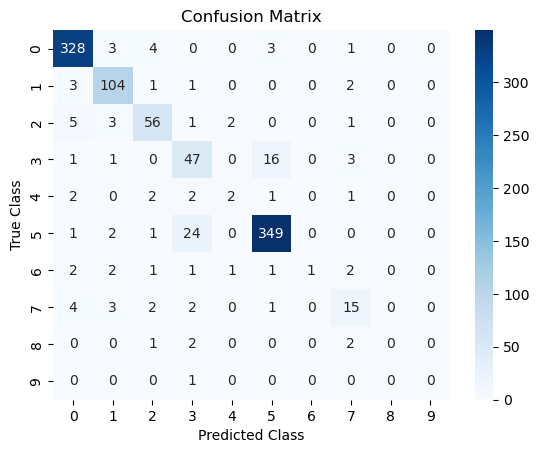


               precision    recall  f1-score   support

     Class 0       0.95      0.97      0.96       339
     Class 1       0.88      0.94      0.91       111
     Class 2       0.82      0.82      0.82        68
     Class 3       0.58      0.69      0.63        68
     Class 4       0.40      0.20      0.27        10
     Class 5       0.94      0.93      0.93       377
     Class 6       1.00      0.09      0.17        11
     Class 7       0.56      0.56      0.56        27
     Class 8       0.00      0.00      0.00         5
     Class 9       0.00      0.00      0.00         1

    accuracy                           0.89      1017
   macro avg       0.61      0.52      0.52      1017
weighted avg       0.88      0.89      0.88      1017



C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1

In [37]:
create_heatmap_and_error_report(model,X_test,Y_hazard_category_test,1)

In [39]:
#read the validation_file for hazard category and create a prediction vector

#load the csv incidents_val into a data frame

df_validation=pd.read_csv('incidents_val.csv')
#df.head()

#isolate the text category which is to be used as the input X to a classifier
text_validation=df_validation['text']

In [42]:
#follow the same steps as before to vectorize the text_validation 
#into a form that can be loaded into the trained model

#to avoid having different number of features for the train set and the validation set with the tfidf vectorizer we are 
#going to use the tfidf vectorizer fitted for the train set to the validation set 
#the function we created previously will not suffise because it will create a unique representation based on the validation set 
#with number of features different than the ones in the training set

tfidf_vectorizer = TfidfVectorizer()  #create a tfidfvectorizer object


tfidf_vectorizer.fit(text)        #fit it for the text of the training set 
                                                   
X_center=tfidf_vectorizer.transform(text)      #transform the title of the training set into a format where each entry is a 
                                                #numeric vector of shape (m,n) where m 
                                                #is the number of examples in the given set and n is the number of features

X_center_format=X_center.toarray()             #follow this conversion to get an array form
                                               #


X_val_0=tfidf_vectorizer.transform(text_validation)   #use the vectorizer that is fitted to the training set to transform the input 
                                                       #from the validation set. the result will be a numeric vector of shape (m_val,n)
                                                       #where m_val is the number of entries in the validation set and 
                                                       #n is the number of features which is the same as the number of features 
                                                       # used for training

X_val_1=X_val_0.toarray()

X_val_1.shape

(565, 41409)

In [44]:
#predictions in text format from the trained dense model named model

HZ_val_prediction=from_pred_and_dictionary_to_labels(X_val_1,model,one_hot_encode_hazard_category)  #use the aforementioned function
                                                       #to predict the Hazard category labels for the validation set using the 
                                                       #validation title. This function also receives as input the dictionary with 
                                                       #the labels and their one hot encoding in order to convert the predictions back to text

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [45]:
#HZ_val_prediction

In [49]:
#now we are going to follow the exact same procedure and train a seperate model to predict 
#the product category first for the training set and then for the validation set


In [51]:
product_category=df['product-category'] #get the product category for the data frame refering to the training set
unique_product_category_labels=find_unique_column_labels(product_category) #find the unique labels of product category

one_hot_encode_product_category=one_hot_encode_labels(unique_product_category_labels) #one hot encode these labels and get a 
#dictionary with the key being the label and the value being its one hot encoding


Y_product_category_transposed=create_Y_label(product_category,one_hot_encode_product_category)
#create the Y part of the data set

Y_product_category=Y_product_category_transposed.T
Y_product_category.shape

(5082, 22)

In [53]:
#split the data intro train and test set
#using the processed text data as X
#and product category as Y
X_train, X_test, Y_product_category_train, Y_product_category_test = train_test_split(X, Y_product_category, test_size=0.2, random_state=42)

In [56]:
#train a different dense net than before in order to predict the product-category column of the data frame
#22 is the number of unique categories for product-category
model_2=train_and_eval_dense_nn(X_train,Y_product_category_train,X_test,Y_product_category_test,256,128,22,4,32)

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/4
128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - accuracy: 0.3056 - loss: 2.5230 - val_accuracy: 0.4700 - val_loss: 1.7543
Epoch 2/4
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - accuracy: 0.6413 - loss: 1.2872 - val_accuracy: 0.6618 - val_loss: 1.2060
Epoch 3/4
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - accuracy: 0.9144 - loss: 0.4198 - val_accuracy: 0.7227 - val_loss: 1.0621
Epoch 4/4
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.9709 - loss: 0.1483 - val_accuracy: 0.7217 - val_loss: 1.0654
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7150 - loss: 1.1052
Test Loss: 1.0654250383377075
Test Accuracy: 0.7217305898666382


In [58]:
Y_product_category_test.shape

(1017, 22)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


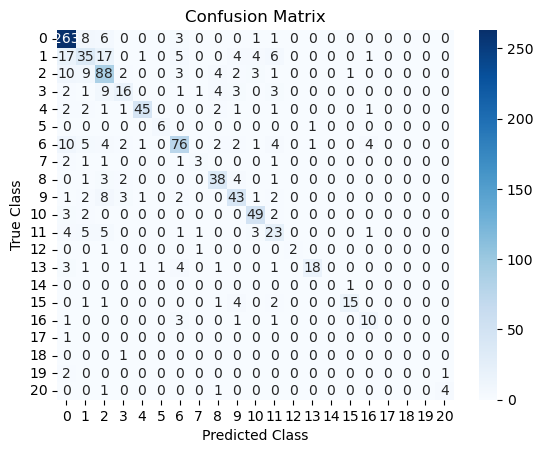


               precision    recall  f1-score   support

     Class 0       0.82      0.93      0.87       282
     Class 1       0.48      0.39      0.43        90
     Class 2       0.61      0.72      0.66       123
     Class 3       0.57      0.40      0.47        40
     Class 4       0.92      0.80      0.86        56
     Class 5       0.86      0.86      0.86         7
     Class 6       0.77      0.68      0.72       112
     Class 7       0.50      0.33      0.40         9
     Class 8       0.72      0.78      0.75        49
     Class 9       0.67      0.68      0.68        63
    Class 10       0.79      0.88      0.83        56
    Class 11       0.47      0.53      0.50        43
    Class 12       1.00      0.50      0.67         4
    Class 13       0.90      0.58      0.71        31
    Class 14       0.00      0.00      0.00         1
    Class 15       0.88      0.62      0.73        24
    Class 16       0.59      0.62      0.61        16
    Class 17       0.00  

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1

In [60]:
create_heatmap_and_error_report(model_2,X_test,Y_product_category_test,Y_product_category_test.shape[1])

In [62]:
#follow the same steps as before to vectorize the text_validation 
#into a form that can be loaded into the trained model

#to avoid having different number of features for the train set and the validation set with the tfidf vectorizer we are 
#going to use the tfidf vectorizer fitted for the train set to the validation set 
#the function we created previously will not suffise because it will create a unique representation based on the validation set 
#with number of features different than the ones in the training set

tfidf_vectorizer = TfidfVectorizer()  #create a tfidfvectorizer object


tfidf_vectorizer.fit(text)        #fit it for the title of the training set 
                                                   
X_center=tfidf_vectorizer.transform(text)      #transform the title of the training set into a format where each entry is a 
                                                #numeric vector of shape (m,n) where m 
                                                #is the number of examples in the given set and n is the number of features

X_center_format=X_center.toarray()             #follow this conversion to get an array form
                                               #


X_val_0=tfidf_vectorizer.transform(text_validation)   #use the vectorizer that is fitted to the training set to transform the input 
                                                       #from the validation set. the result will be a numeric vector of shape (m_val,n)
                                                       #where m_val is the number of entries in the validation set and 
                                                       #n is the number of features which is the same as the number of features 
                                                       # used for training

X_val_1=X_val_0.toarray()

X_val_1.shape

(565, 41409)

In [64]:
#predictions in text format from the trained dense model named model

PZ_val_prediction=from_pred_and_dictionary_to_labels(X_val_1,model_2,one_hot_encode_product_category)  #use the aforementioned function
                                                       #to predict the product category labels for the validation set using the 
                                                       #validation title. This function also receives as input the dictionary with 
                                                       #the labels and their one hot encoding in order to convert the predictions back to text

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [61]:
#PZ_val_prediction

len(HZ_val_prediction)
len(PZ_val_prediction)

565

In [67]:
#turn the predictions into columns of a new dataframe and save them to a csv file
predicted_data_final={
'hazard-category': HZ_val_prediction,
'product-category': PZ_val_prediction
    
}
df_final=pd.DataFrame(predicted_data_final)

# Save the DataFrame to a CSV file
df_final.to_csv('st1_text_dense.csv', index=False)
